In [1]:
!pip install mrjob scikit-learn matplotlib pandas
!apt-get install openjdk-8-jdk -qq > /dev/null

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 439.6/439.6 kB 6.3 MB/s eta 0:00:00


In [2]:
import pandas as pd

# Load dataset
df = pd.read_csv("/content/world_population.csv", sep=";")
print(df.head())

# Select relevant columns and clean data
population_df = df[['Country/Territory', '2022 Population', '2020 Population',
                   '2015 Population', '2010 Population', '2000 Population']]
population_df = population_df.dropna()
print(population_df.head())

   Rank CCA3 Country/Territory           Capital Continent  2022 Population  \
0    36  AFG       Afghanistan             Kabul      Asia         41128771   
1   138  ALB           Albania            Tirana    Europe          2842321   
2    34  DZA           Algeria           Algiers    Africa         44903225   
3   213  ASM    American Samoa         Pago Pago   Oceania            44273   
4   203  AND           Andorra  Andorra la Vella    Europe            79824   

   2020 Population  2015 Population  2010 Population  2000 Population  \
0         38972230         33753499         28189672         19542982   
1          2866849          2882481          2913399          3182021   
2         43451666         39543154         35856344         30774621   
3            46189            51368            54849            58230   
4            77700            71746            71519            66097   

   1990 Population  1980 Population  1970 Population  Area (km²)  \
0         10694796

In [3]:
%%writefile population_mr.py
from mrjob.job import MRJob
import pandas as pd

class MRPopulationAnalysis(MRJob):
    def mapper(self, _, line):
        if not line.startswith("Rank"):  # Skip header
            parts = line.split(';')
            country = parts[2]
            pop_2022 = float(parts[5])
            yield country, pop_2022

    def reducer(self, country, values):
        pops = list(values)
        yield country, sum(pops)/len(pops)  # Average population

if __name__ == '__main__':
    MRPopulationAnalysis.run()

Writing population_mr.py


In [4]:
!python population_mr.py world_population.csv > population_results.txt

No configs found; falling back on auto-configuration
No configs specified for inline runner
Creating temp directory /tmp/population_mr.root.20250329.191744.837334
Running step 1 of 1...
job output is in /tmp/population_mr.root.20250329.191744.837334/output
Streaming final output from /tmp/population_mr.root.20250329.191744.837334/output...
Removing temp directory /tmp/population_mr.root.20250329.191744.837334...


In [5]:
!cat population_results.txt

"San Marino"	33660.0
"Sao Tome and Principe"	227380.0
"Saudi Arabia"	36408820.0
"Senegal"	17316449.0
"Serbia"	7221365.0
"Seychelles"	107118.0
"Sierra Leone"	8605718.0
"Singapore"	5975689.0
"Sint Maarten"	44175.0
"Slovakia"	5643453.0
"Slovenia"	2119844.0
"Solomon Islands"	724273.0
"Somalia"	17597511.0
"South Africa"	59893885.0
"South Korea"	51815810.0
"South Sudan"	10913164.0
"Spain"	47558630.0
"Sri Lanka"	21832143.0
"Sudan"	46874204.0
"Suriname"	618040.0
"Sweden"	10549347.0
"Switzerland"	8740472.0
"Syria"	22125249.0
"Taiwan"	23893394.0
"Tajikistan"	9952787.0
"Tanzania"	65497748.0
"Thailand"	71697030.0
"Timor-Leste"	1341296.0
"Togo"	8848699.0
"Tokelau"	1871.0
"Tonga"	106858.0
"Trinidad and Tobago"	1531044.0
"Tunisia"	12356117.0
"Turkey"	85341241.0
"Turkmenistan"	6430770.0
"Turks and Caicos Islands"	45703.0
"Tuvalu"	11312.0
"Uganda"	47249585.0
"Ukraine"	39701739.0
"United Arab Emirates"	9441129.0
"United Kingdom"	67508936.0
"United States Virgin Islands"	99465.0
"United States"	338289857

In [10]:
import sqlite3
import pandas as pd

# Load your dataset
df = pd.read_csv("world_population.csv", sep=";")

# Clean column names by removing spaces and special characters
df.columns = [col.replace(' ', '_').replace('(', '').replace(')', '').replace('/', '_') for col in df.columns]

# Select relevant columns
population_df = df[['Country_Territory', '2022_Population', '2020_Population',
                   '2015_Population', '2010_Population', '2000_Population','1990_Population', '1980_Population', '1970_Population']]

# Create SQLite database
conn = sqlite3.connect('population.db')

# Store data - this will automatically create the table with correct column names
population_df.to_sql('world_population', conn, if_exists='replace', index=False)

# Now query with the correct column names
query = "SELECT * FROM world_population WHERE \"2022_Population\" > 100000000"
results = pd.read_sql(query, conn)
print(results)

conn.close()

   Country_Territory  2022_Population  2020_Population  2015_Population  \
0         Bangladesh        171186372        167420951        157830000   
1             Brazil        215313498        213196304        205188205   
2              China       1425887337       1424929781       1393715448   
3              Egypt        110990103        107465134         97723799   
4           Ethiopia        123379924        117190911        102471895   
5              India       1417173173       1396387127       1322866505   
6          Indonesia        275501339        271857970        259091970   
7              Japan        123951692        125244761        127250933   
8             Mexico        127504125        125998302        120149897   
9            Nigeria        218541212        208327405        183995785   
10          Pakistan        235824862        227196741        210969298   
11       Philippines        115559009        112190977        103031365   
12            Russia     

In [12]:

from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
import numpy as np

# Prepare data (using 2000-2022 data for regression)
X = np.array([1970, 1980, 1990, 2000, 2010, 2015, 2020, 2022]).reshape(-1, 1)
y = population_df.iloc[0][['1970_Population', '1980_Population', '1990_Population','2000_Population', '2010_Population',
                           '2015_Population', '2020_Population', '2022_Population']].values

# Train polynomial regression model (degree 2 for better curve fitting)
degree = 2
model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
model.fit(X, y)

# Predict for 2030 and 2050
future_years = np.array([2030, 2050]).reshape(-1, 1)
predictions = model.predict(future_years)

print(f"Predicted population for {population_df.iloc[0]['Country_Territory']}:")
for year, pop in zip(future_years.flatten(), predictions.flatten()):
    print(f"{year}: {pop:,.0f}")


Predicted population for Afghanistan:
2030: 53,726,935
2050: 91,872,578


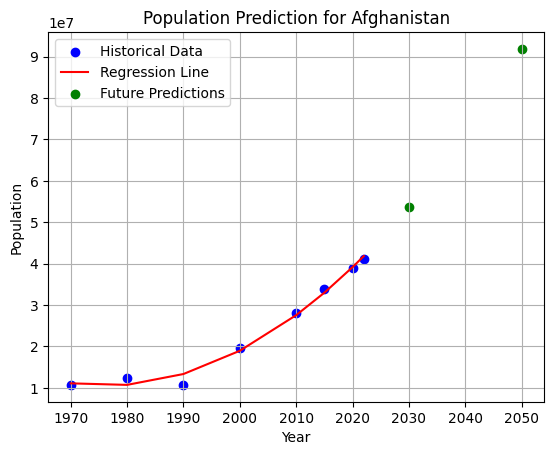

In [14]:
import matplotlib.pyplot as plt

# Historical data
years = [1970, 1980, 1990, 2000, 2010, 2015, 2020, 2022]
plt.scatter(years, y, color='blue', label='Historical Data')

# Regression line
plt.plot(years, model.predict(np.array(years).reshape(-1, 1)), 'r-', label='Regression Line')

# Predictions
plt.scatter(future_years, predictions, color='green', label='Future Predictions')

plt.xlabel('Year')
plt.ylabel('Population')
plt.title(f"Population Prediction for {population_df.iloc[0]['Country_Territory']}")
plt.legend()
plt.grid(True)
plt.show()